In [9]:
import numpy as np
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
!pip install nlpaug

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [12]:
import nltk
import pandas as pd
import nlpaug.augmenter.word as naw

# Download NLTK resources
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("imdb_reviews_with_classes.csv")

# Define synonym augmentation
aug = naw.SynonymAug(aug_src="wordnet", aug_p=0.3)

# Class distribution
class_counts = df["Sentiment"].value_counts()
max_class_size = class_counts.max()  # 7756 (Positive)

# Function to augment minority class until it matches majority class
def augment_class(df_class, target_size):
    augmented_reviews = []
    while len(augmented_reviews) + len(df_class) < target_size:
        for review in df_class["Review Title"]:
            if isinstance(review, str) and review.strip():
                augmented_reviews.append(aug.augment(review)[0])
                if len(augmented_reviews) + len(df_class) >= target_size:
                    break  # Stop if we reach target size

    # Create DataFrame for augmented data
    df_augmented = df_class.copy()
    df_augmented = df_augmented.sample(len(augmented_reviews), replace=True, random_state=42)  # Duplicate existing rows
    df_augmented["Review Title"] = augmented_reviews  # Replace text with augmented reviews

    return df_augmented

# Augment Neutral and Negative classes
df_negative = df[df["Sentiment"] == "Negative"]
df_neutral = df[df["Sentiment"] == "Neutral"]

df_negative_augmented = augment_class(df_negative, max_class_size)
df_neutral_augmented = augment_class(df_neutral, max_class_size)

# Combine datasets
df_balanced = pd.concat([df, df_negative_augmented, df_neutral_augmented], ignore_index=True)

# Save the balanced dataset
df_balanced.to_csv("balanced_imdb_reviews.csv", index=False)

print("✅ Balanced dataset created successfully!")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Balanced dataset created successfully!


In [13]:
df = pd.read_csv("balanced_imdb_reviews.csv")

In [14]:
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,7756
Neutral,7756
Negative,7756


In [15]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels into integer labels
label_encoder = LabelEncoder()
df['Sentiment_label'] = label_encoder.fit_transform(df['Sentiment'])  # 0 = negative, 1 = neutral, 2 = positive

In [16]:
df.head(10)

,Review Title,Rating,Sentiment,Sentiment_label
0,Awards worthy cinematography and acting,9,Positive,2
1,Very scary but important,9,Positive,2
2,I have never seen anything like this...,10,Positive,2
3,Hand that boy the Emmy!!!,10,Positive,2
4,wow,10,Positive,2
5,Every episode punches your gut,10,Positive,2
6,Tense and Gripping Drama,10,Positive,2
7,The Anti-Social Network,10,Positive,2
8,Perplexed by the rave reviews.,6,Neutral,1
9,Unbelievably good,10,Positive,2


In [17]:
from sklearn.model_selection import train_test_split

X = df['Review Title']
y = df['Sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

VOCAB_SIZE = 20000
MAX_LENGTH = 100

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")

In [19]:
import pickle

# Save tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
import numpy as np

# Load GloVe word embeddings
embedding_index = {}
glove_path = "glove.6B.100d.txt"  # Ensure this is the correct path

with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype="float32")

        # Ensure only vectors of the correct dimension are stored
        if coefficients.shape[0] == 100:  # Must match embedding_dim
            embedding_index[word] = coefficients

embedding_dim = 100
embedding_matrix = np.random.uniform(-0.05, 0.05, (VOCAB_SIZE, embedding_dim))  # Random small values

for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Use GloVe if available

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout

model = Sequential([
    Embedding(VOCAB_SIZE, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: Positive, Negative, Neutral
])

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [22]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 205s 342ms/step - accuracy: 0.5185 - loss: 0.9433 - val_accuracy: 0.6076 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 200s 343ms/step - accuracy: 0.6205 - loss: 0.7939 - val_accuracy: 0.6442 - val_loss: 0.7483 - learning_rate: 0.0010
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 196s 338ms/step - accuracy: 0.6710 - loss: 0.7168 - val_accuracy: 0.6850 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 207s 346ms/step - accuracy: 0.7169 - loss: 0.6286 - val_accuracy: 0.7054 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 192s 331ms/step - accuracy: 0.7651 - loss: 0.5405 - val_accuracy: 0.7355 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 200s 344ms/step - accuracy: 0.8012 - loss: 0.4637 - val_accuracy: 0.7587 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 203s 346ms/step - accura

In [23]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step
              precision    recall  f1-score   support

    Negative       0.76      0.79      0.77      1520
     Neutral       0.73      0.73      0.73      1571
    Positive       0.84      0.80      0.82      1563

    accuracy                           0.77      4654
   macro avg       0.77      0.77      0.77      4654
weighted avg       0.77      0.77      0.77      4654



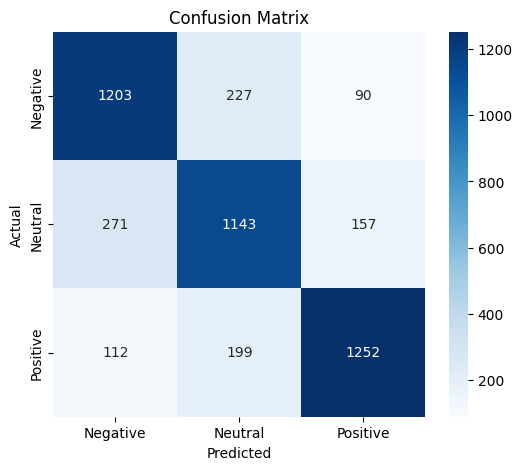

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

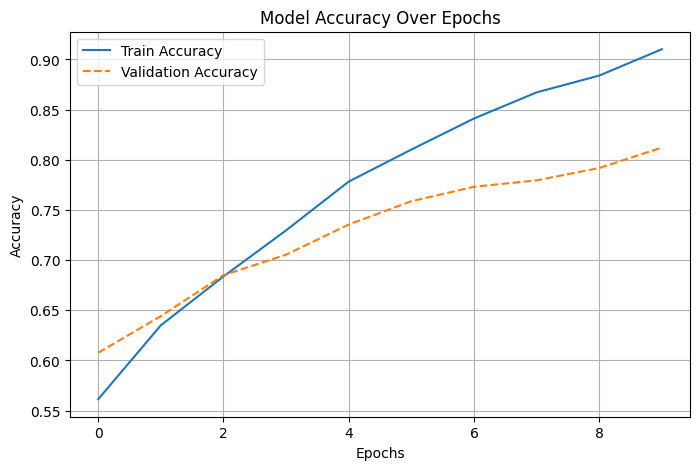

In [36]:
import matplotlib.pyplot as plt

# Ensure 'history' exists
if 'history' in locals():
    # Plot training & validation accuracy
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: 'history' object not found. Make sure model.fit() has been executed.")

In [35]:
def predict_sentiment(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=MAX_LENGTH, padding="post")
    prediction = model.predict(text_pad)
    labels = ["Negative", "Neutral", "Positive"]
    return labels[np.argmax(prediction)]

# Example
print(predict_sentiment("Movie is good"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Positive


In [29]:
model.save("sentiment_model.keras")

In [31]:
from google.colab import files

files.download('sentiment_model.keras')

files.download('tokenizer.pickle')

files.download('balanced_imdb_reviews.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>